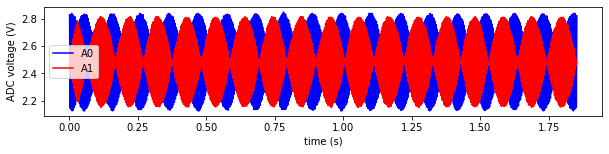

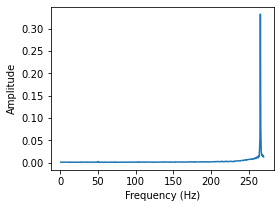

Fundamental frequency at 265.6707475828961, with amplitude 0.3326232135295868.
Nyquist frequency as last point in FFT = 269.99939520135473


In [4]:
import numpy

def read_arduino_2ch_diff(number_readings=1, data_type=numpy.float32, error_value=numpy.NaN,
                          serial_port='COM3', baud_rate=115200, timeout=2, delay=0, # NEW
                          terminator='\r\n', startup_message='Yours sincerely, Arduino'): 
    '''
    Returns number_readings (default 1) pairs of voltage measurements from Arduino 
    attached to serial_port at baud_rate with specified timeout.
    Each pair of comma-separated voltage readings, and time-delta from Arduino should 
    be terminated with terminator (string), and it should give a suitable startup 
    message (string).  
    Returns a numpy array of shape (2, number_readings), of type data_type, and a numpy
    array of timestamps of same shape and type numpy.float32. 
    Returns element with error_value if value cannot be converted to type data_type, but
    attempts to correct timestamp array for errors.
    '''
    if number_readings < 1: number_readings = 1 
    numeric_values = numpy.zeros((2, number_readings), dtype=data_type) 
    time_diffs = numpy.zeros((number_readings,), dtype=numpy.uint32) # NEW
    
    import serial
    with serial.Serial(port=serial_port, baudrate=baud_rate, timeout=timeout) as arduino:
        arduino.read_until(startup_message.encode()) 
        for i in range(number_readings): 
            data = arduino.read_until(terminator.encode())
            values = data.decode().strip().split(',') # produce 3-element list
            try:
                numeric_values[0, i] = data_type(values[0]) 
                numeric_values[1, i] = data_type(values[1]) 
                time_diffs[i] = numpy.uint32(values[2])# NEW: extra value 
            except (ValueError, IndexError): 
                numeric_values[0, i] = error_value 
                numeric_values[1, i] = error_value 
                # NEW: extra value - zero in case of errors.
                # We can't use NaN as it is a 'float' not an 'int'!
                time_diffs[i] = 0 
                                
    
    timestamps = reconstruct_timestamps(time_diffs, 2, delay) # NEW: time_diffs -> timestamps
    
    return numeric_values, timestamps*1e-6 # NEW: return timestamps in [s]


def reconstruct_timestamps(diffs, n_channels, delay=0):
    '''
    More robust reconstruction of corrected timestamp array: any zero values
    in 'diffs' due to errors are replaced with the modal value of the rest
    of the array, before making the cumulative sum.
    '''
    from scipy.stats import mode
    try: # Determine the most common (mode) of the valid time_diff values
        mode_diff = mode(diffs[diffs != 0]).mode[0]     
    except IndexError: # If ALL diffs are zero, due to errors, mode.mode = []
        print('Your Arduino sketch is not compatible with this function!')
        mode_diff = 0 #  This will still return array of zeros for timestamps
        
    timestamps = numpy.where(diffs == 0, # replace invalid values
                             mode_diff, # with most common valid value
                             diffs).cumsum() # then take cumulative sum
    return numpy.array([timestamps + i*delay for i in range(n_channels)])

%matplotlib inline
import matplotlib.pyplot as plt

def plot_signals(signals, times, plot=True):
    '''Plots a graph of the 2D numpy array 'signals' of
    two-channel data, vs times array of same shape, if plot=True.'''
    if plot: # only plot graph if plot=True
        plt.figure(figsize=(10,2))
        plt.plot(times[0], signals[0], 'b', label='A0')
        plt.plot(times[1], signals[1], 'r', label='A1')
        plt.legend()
        plt.xlabel('time (s)'); plt.ylabel('ADC voltage (V)')
        plt.show()
        
def FFT(signal, time, plot=True):
    '''
    Determine and plot (positive frequency) FFT of signal with timebase time 
    (both numpy arrays).
    Returns frequency and amplitude of (non-zero frequency) fundamental tone.
    '''
    from scipy.fftpack import fft

    yf = 2.0/len(signal) * numpy.abs(fft(signal)[:len(signal)//2])[1:] 
    xf = numpy.linspace(0.0, len(time)/(2.0*(time[-1]-time[0])), len(time)//2)[1:]
    peak_freq = xf[numpy.argmax(yf)]
    amplitude = numpy.max(yf)
        
    if plot: # only plot graph if plot=True
        plt.figure(figsize=(4,3))
        plt.plot(xf, yf)
        plt.xlabel('Frequency (Hz)'); plt.ylabel('Amplitude')
        plt.show() 
        print('Fundamental frequency at {}, with amplitude {}.'.format(peak_freq, amplitude))
        print('Nyquist frequency as last point in FFT = {}'.format(xf[-1]))
    
    return peak_freq, amplitude

signals, times = read_arduino_2ch_diff(number_readings=1000)
plot_signals(signals, times)
f0, A0 = FFT(signals[0], times[0])
